# Apple Health & Freestyle Libre 3 Data Analysis
## 04 - Apple Health Exploratory Analysis

This notebook dives deep into the Apple Health dataset to understand data coverage, sensor mix, and potential modeling features without incorporating external glucose data.

**Notebook objectives:**
- Reload the cleaned Apple Health export and supporting metadata
- Audit data quality, coverage, and rich sensor availability
- Explore key physiological domains such as heart rate, activity, and sleep
- Engineer reusable aggregates for downstream modeling and visualization
- Export curated Apple Health summaries for Notebook 05 and beyond

In [14]:
# Import libraries and configure the environment
import json
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from IPython.display import Markdown, display

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 120)
pd.set_option("display.precision", 3)
sns.set_theme(style="whitegrid", palette="husl")

print("✅ Libraries imported and visualization style configured")

✅ Libraries imported and visualization style configured


### 1. Load Apple Health dataset and metadata

In [15]:
project_root = Path("..")
processed_dir = project_root / "data" / "processed"
processed_dir.mkdir(exist_ok=True)

apple_path = processed_dir / "apple_health_cleaned.csv"
summary_path = processed_dir / "data_summary.json"

print(f"📂 Processed data directory: {processed_dir.resolve()}")

date_columns = ["startDate", "endDate", "creationDate"]
apple_df = pd.DataFrame()

if apple_path.exists():
    preview = pd.read_csv(apple_path, nrows=0)
    parsed_cols = [col for col in date_columns if col in preview.columns]
    apple_df = pd.read_csv(apple_path, parse_dates=parsed_cols)
    print(f"✅ Loaded Apple Health dataset with {len(apple_df):,} records")
else:
    print(
        f"⚠️ Apple Health dataset not found at {apple_path}. Generating sample data for walkthrough."
    )

    date_range = pd.date_range(start="2024-01-01", periods=500, freq="6H")
    np.random.seed(42)
    apple_df = pd.DataFrame(
        {
            "type": np.random.choice(
                [
                    "HKQuantityTypeIdentifierHeartRate",
                    "HKQuantityTypeIdentifierStepCount",
                    "HKQuantityTypeIdentifierActiveEnergyBurned",
                    "HKCategoryTypeIdentifierSleepAnalysis",
                ],
                size=len(date_range),
            ),
            "sourceName": np.random.choice(
                ["Apple Watch", "iPhone", "Beddit"], size=len(date_range)
            ),
            "value": np.random.gamma(shape=2.0, scale=40, size=len(date_range)),
            "unit": "count/min",
            "creationDate": date_range
            + pd.to_timedelta(np.random.randint(0, 3600, len(date_range)), unit="s"),
            "startDate": date_range,
            "endDate": date_range + pd.to_timedelta(5, unit="m"),
        }
    )
    print(
        f"🧪 Sample Apple Health dataset created with {len(apple_df):,} synthetic records"
    )

# Ensure datetime columns are timezone-naive
for col in [c for c in date_columns if c in apple_df.columns]:
    apple_df[col] = pd.to_datetime(apple_df[col], errors="coerce")
    if hasattr(apple_df[col].dt, "tz") and apple_df[col].dt.tz is not None:
        apple_df[col] = apple_df[col].dt.tz_convert("US/Eastern").dt.tz_localize(None)

# Create helper columns for analysis
apple_df["value_numeric"] = pd.to_numeric(apple_df.get("value"), errors="coerce")
apple_df["type_clean"] = apple_df.get("type", "unknown").str.replace(
    "HKQuantityTypeIdentifier", "", regex=False
)
apple_df["type_clean"] = apple_df["type_clean"].str.replace(
    "HKCategoryTypeIdentifier", "", regex=False
)
apple_df["type_clean"] = apple_df["type_clean"].str.replace(
    "HKCorrelationTypeIdentifier", "", regex=False
)

if "startDate" in apple_df.columns:
    apple_df["event_date"] = apple_df["startDate"].dt.floor("D")
    apple_df["event_hour"] = apple_df["startDate"].dt.hour

summary_metadata = {}
if summary_path.exists():
    with open(summary_path, "r") as f:
        summary_metadata = json.load(f)
        print("📖 Loaded existing data_summary.json")
else:
    print("ℹ️ No prior data_summary.json found; continuing without metadata context.")

📂 Processed data directory: /Users/george/Library/Mobile Documents/com~apple~CloudDocs/Programming Projects/Apple-Health-DS/data/processed
✅ Loaded Apple Health dataset with 114,252 records
📖 Loaded existing data_summary.json
✅ Loaded Apple Health dataset with 114,252 records
📖 Loaded existing data_summary.json


### 2. Quick dataset snapshot

In [16]:
if apple_df.empty:
    print(
        "⚠️ Apple Health dataframe is empty. Review Notebook 01 exports before proceeding."
    )
else:
    n_rows, n_cols = apple_df.shape
    print(f"📊 Apple Health dataframe shape: {n_rows:,} rows × {n_cols} columns")
    print(f"🔁 Unique record types: {apple_df['type_clean'].nunique()}")
    print(f"🪪 Data sources: {apple_df['sourceName'].nunique()}")

    display(Markdown("**Column overview:**"))
    display(
        pd.DataFrame(
            {"dtype": apple_df.dtypes.astype(str), "non_nulls": apple_df.notna().sum()}
        ).sort_index()
    )

    display(Markdown("**Sample records:**"))
    display(apple_df.head(10))

📊 Apple Health dataframe shape: 114,252 rows × 11 columns
🔁 Unique record types: 43
🪪 Data sources: 8


**Column overview:**

,dtype,non_nulls
creationDate,datetime64[ns],114252
endDate,datetime64[ns],114252
event_date,datetime64[ns],114252
event_hour,int32,114252
sourceName,object,114252
startDate,datetime64[ns],114252
type,object,114252
type_clean,object,114252
unit,object,111972
value,float64,111972


**Sample records:**

,type,sourceName,value,unit,creationDate,startDate,endDate,value_numeric,type_clean,event_date,event_hour
0,HKQuantityTypeIdentifierBloodGlucose,Bevel,125.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:20:01,2025-08-16 13:20:01,125.0,BloodGlucose,2025-08-16,13
1,HKQuantityTypeIdentifierBloodGlucose,Bevel,124.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:25:00,2025-08-16 13:25:00,124.0,BloodGlucose,2025-08-16,13
2,HKQuantityTypeIdentifierBloodGlucose,Bevel,127.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:30:02,2025-08-16 13:30:02,127.0,BloodGlucose,2025-08-16,13
3,HKQuantityTypeIdentifierBloodGlucose,Bevel,125.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:35:01,2025-08-16 13:35:01,125.0,BloodGlucose,2025-08-16,13
4,HKQuantityTypeIdentifierBloodGlucose,Bevel,119.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:40:15,2025-08-16 13:40:15,119.0,BloodGlucose,2025-08-16,13
5,HKQuantityTypeIdentifierBloodGlucose,Bevel,110.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:45:23,2025-08-16 13:45:23,110.0,BloodGlucose,2025-08-16,13
6,HKQuantityTypeIdentifierBloodGlucose,Bevel,105.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:50:01,2025-08-16 13:50:01,105.0,BloodGlucose,2025-08-16,13
7,HKQuantityTypeIdentifierBloodGlucose,Bevel,96.0,mg/dL,2025-08-17 00:38:00,2025-08-16 13:55:02,2025-08-16 13:55:02,96.0,BloodGlucose,2025-08-16,13
8,HKQuantityTypeIdentifierBloodGlucose,Bevel,87.0,mg/dL,2025-08-17 00:38:00,2025-08-16 14:00:02,2025-08-16 14:00:02,87.0,BloodGlucose,2025-08-16,14
9,HKQuantityTypeIdentifierBloodGlucose,Bevel,89.0,mg/dL,2025-08-17 00:38:00,2025-08-16 14:05:01,2025-08-16 14:05:01,89.0,BloodGlucose,2025-08-16,14


### 3. Data-quality diagnostics

In [17]:
def build_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()

    quality = pd.DataFrame(
        {
            "metric": [
                "rows",
                "columns",
                "duplicate_rows",
                "missing_value_pct",
                "min_start",
                "max_start",
            ],
            "value": [
                len(df),
                len(df.columns),
                int(df.duplicated().sum()),
                round(df.isna().mean().mean() * 100, 3),
                (
                    df.get("startDate").min().isoformat()
                    if "startDate" in df and df["startDate"].notna().any()
                    else None
                ),
                (
                    df.get("startDate").max().isoformat()
                    if "startDate" in df and df["startDate"].notna().any()
                    else None
                ),
            ],
        }
    )
    return quality


if apple_df.empty:
    print("⚠️ Skipping quality diagnostics because dataframe is empty.")
else:
    quality_report = build_quality_report(apple_df)
    display(Markdown("**Dataset health overview:**"))
    display(quality_report)

    missingness = apple_df.isna().mean().sort_values(ascending=False) * 100
    missingness = missingness[missingness > 0]
    if not missingness.empty:
        display(Markdown("**Columns with missing values (%):**"))
        display(missingness.round(3).to_frame(name="missing_pct"))
    else:
        print("✅ No missing values detected across columns.")

**Dataset health overview:**

,metric,value
0,rows,114252
1,columns,11
2,duplicate_rows,1689
3,missing_value_pct,0.544
4,min_start,2025-08-16T13:20:00
5,max_start,2025-08-30T17:54:00


**Columns with missing values (%):**

,missing_pct
value,1.996
unit,1.996
value_numeric,1.996


### 4. Record type distribution

In [18]:
if apple_df.empty:
    print("⚠️ No Apple Health records available.")
else:
    type_counts = (
        apple_df["type_clean"]
        .value_counts()
        .rename_axis("type")
        .reset_index(name="count")
    )
    display(Markdown("**Top 20 record types:**"))
    display(type_counts.head(20))

    fig = px.bar(
        type_counts.head(20),
        x="count",
        y="type",
        orientation="h",
        title="Top Apple Health record types",
        labels={"count": "Records", "type": "Record type"},
        height=600,
    )
    fig.update_layout(yaxis={"categoryorder": "total ascending"})
    fig.show()

**Top 20 record types:**

,type,count
0,HeartRate,33396
1,ActiveEnergyBurned,26578
2,BasalEnergyBurned,18849
3,RespiratoryRate,9007
4,PhysicalEffort,7658
5,DistanceCycling,3478
6,DistanceWalkingRunning,2460
7,SleepAnalysis,1911
8,AppleExerciseTime,1910
9,StepCount,1868


### 5. Temporal coverage and data volume

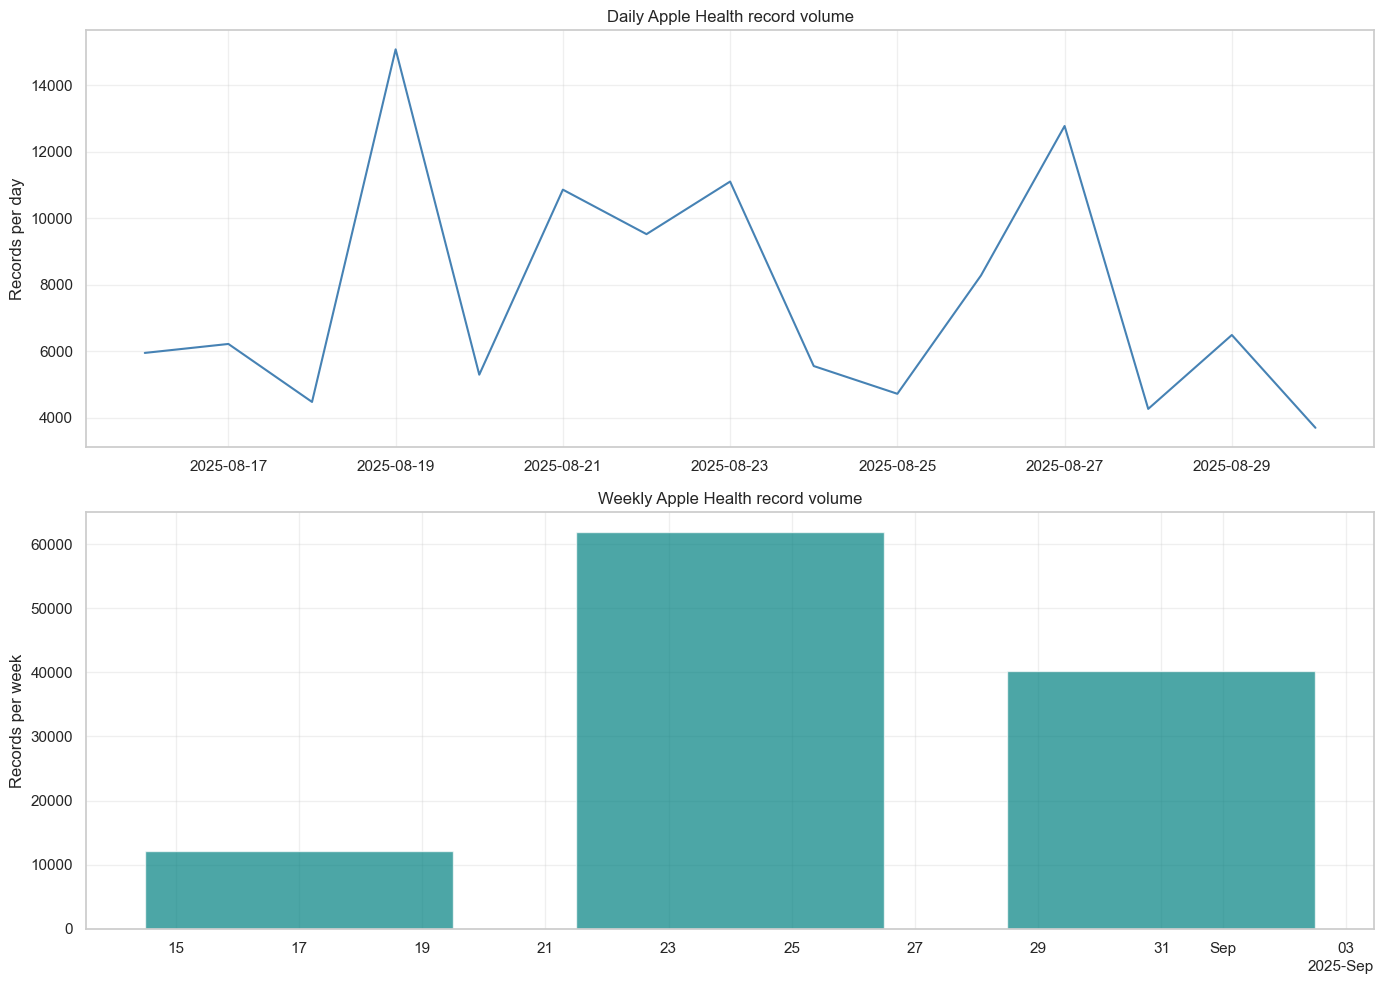

📅 Coverage span: 2025-08-16 00:00:00 → 2025-08-30 00:00:00 (15 days)
📈 Median records/day: 6215


In [19]:
if apple_df.empty or "startDate" not in apple_df.columns:
    print("⚠️ Temporal coverage plot skipped; startDate column missing.")
else:
    daily_counts = apple_df.groupby("event_date").size()
    weekly_counts = apple_df.groupby(pd.Grouper(key="startDate", freq="W")).size()

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=False)
    axes[0].plot(
        daily_counts.index, daily_counts.values, color="steelblue", linewidth=1.5
    )
    axes[0].set_title("Daily Apple Health record volume")
    axes[0].set_ylabel("Records per day")
    axes[0].grid(alpha=0.3)

    axes[1].bar(
        weekly_counts.index, weekly_counts.values, width=5, color="teal", alpha=0.7
    )
    axes[1].set_title("Weekly Apple Health record volume")
    axes[1].set_ylabel("Records per week")
    axes[1].grid(alpha=0.3)
    axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[1].xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(mdates.AutoDateLocator())
    )

    plt.tight_layout()
    plt.show()

    coverage_start = daily_counts.index.min()
    coverage_end = daily_counts.index.max()
    print(
        f"📅 Coverage span: {coverage_start} → {coverage_end} ({len(daily_counts)} days)"
    )
    print(f"📈 Median records/day: {daily_counts.median():.0f}")

### 6. Heart rate analytics

**Heart rate daily summary:**

,count,mean,median,min,max
event_date,,,,,
2025-08-21,2930,86.515,84.0,20.261,153.0
2025-08-22,2554,74.952,74.0,26.070,106.0
2025-08-23,3295,84.271,85.0,18.573,137.0
2025-08-24,1916,71.930,73.0,29.156,113.0
2025-08-25,1871,72.248,70.0,15.670,133.0
2025-08-26,2419,84.467,77.0,14.990,159.0
2025-08-27,3106,82.502,84.5,19.445,156.0
2025-08-28,1669,66.244,65.0,25.323,126.0
2025-08-29,2024,69.975,70.0,29.512,143.0


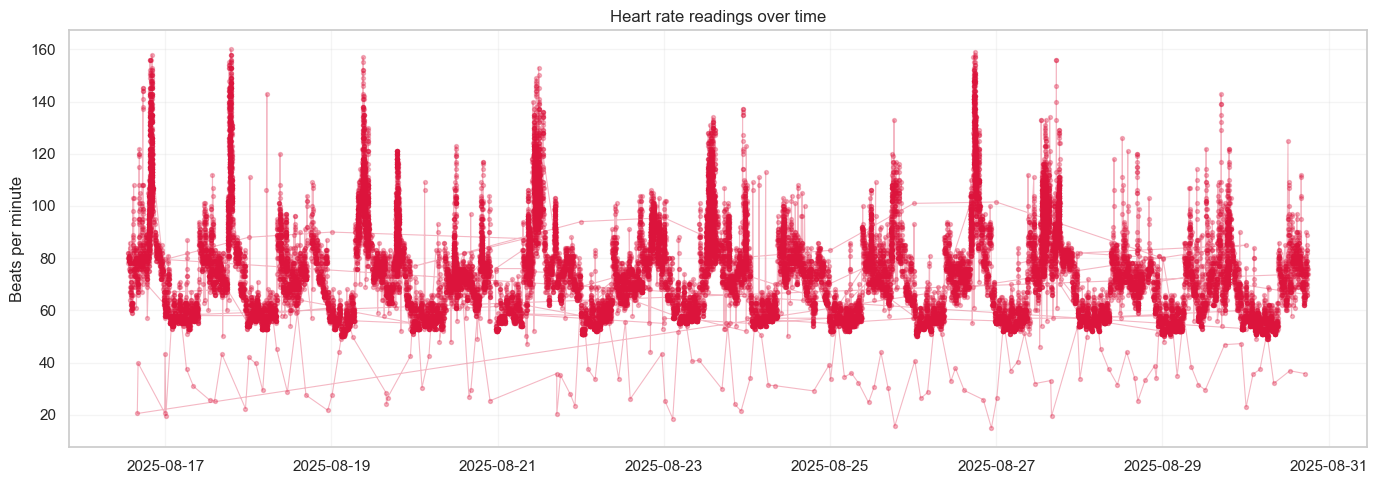

In [20]:
heart_df = apple_df[apple_df["type"].str.contains("HeartRate", na=False)].copy()

if heart_df.empty:
    print("ℹ️ No heart rate records detected in this export.")
else:
    heart_df = heart_df.dropna(subset=["value_numeric", "startDate"])
    heart_df["event_hour"] = heart_df["startDate"].dt.hour

    daily_hr = heart_df.groupby("event_date")["value_numeric"].agg(
        ["count", "mean", "median", "min", "max"]
    )
    display(Markdown("**Heart rate daily summary:**"))
    display(daily_hr.tail(10))

    plt.figure(figsize=(14, 5))
    plt.plot(
        heart_df["startDate"],
        heart_df["value_numeric"],
        color="crimson",
        alpha=0.3,
        linewidth=0.8,
    )
    plt.scatter(
        heart_df["startDate"],
        heart_df["value_numeric"],
        s=8,
        color="crimson",
        alpha=0.3,
    )
    plt.title("Heart rate readings over time")
    plt.ylabel("Beats per minute")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    hourly_profile = heart_df.groupby("event_hour")["value_numeric"].agg(
        ["mean", "count"]
    )
    fig = px.line(
        hourly_profile.reset_index(),
        x="event_hour",
        y="mean",
        markers=True,
        title="Average heart rate by hour of day",
        labels={"event_hour": "Hour", "mean": "Avg BPM"},
    )
    fig.update_traces(line_color="crimson")
    fig.show()

### 7. Activity and energy expenditure

**Daily activity summary (last 14 days):**

type_clean,ActiveEnergyBurned,AppleExerciseTime,DistanceWalkingRunning,StepCount
event_date,,,,
2025-08-17,869.902,59.0,6.973,14225.0
2025-08-18,724.797,33.0,8.361,17614.0
2025-08-19,1132.204,260.0,8.424,16937.0
2025-08-20,765.855,35.0,7.607,16057.0
2025-08-21,1336.660,251.0,9.605,20193.0
2025-08-22,1637.791,268.0,22.468,39929.0
2025-08-23,1472.412,258.0,12.487,26050.0
2025-08-24,865.269,37.0,9.909,21246.0
2025-08-25,701.811,35.0,7.828,16531.0


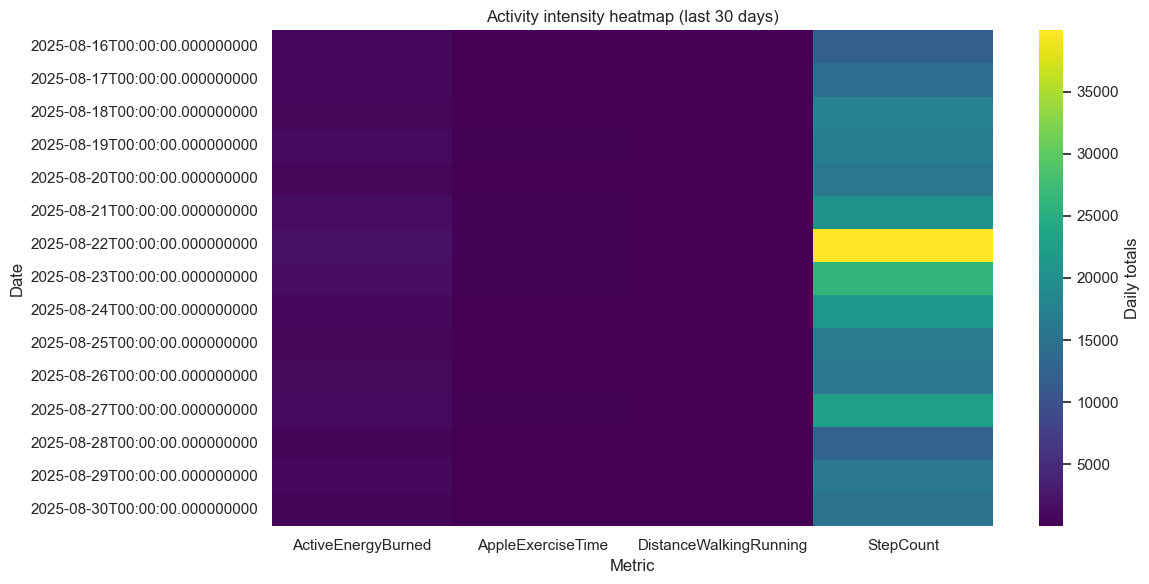

In [21]:
activity_types = [
    "StepCount",
    "DistanceWalkingRunning",
    "ActiveEnergyBurned",
    "AppleExerciseTime",
]
activity_df = apple_df[apple_df["type_clean"].isin(activity_types)].copy()

if activity_df.empty:
    print("ℹ️ No core activity metrics found.")
else:
    activity_df = activity_df.dropna(subset=["value_numeric", "event_date"])
    daily_activity = activity_df.pivot_table(
        index="event_date",
        columns="type_clean",
        values="value_numeric",
        aggfunc="sum",
    ).fillna(0)

    display(Markdown("**Daily activity summary (last 14 days):**"))
    display(daily_activity.tail(14))

    melted = daily_activity.reset_index().melt(
        id_vars="event_date", var_name="metric", value_name="value"
    )
    melted = melted[melted["value"] > 0]
    if not melted.empty:
        fig = px.line(
            melted,
            x="event_date",
            y="value",
            color="metric",
            title="Daily activity trends",
            labels={"event_date": "Date", "value": "Daily total"},
            markers=True,
        )
        fig.show()
    else:
        print("ℹ️ Activity totals are zero after filtering.")

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        daily_activity.tail(30), cmap="viridis", cbar_kws={"label": "Daily totals"}
    )
    plt.title("Activity intensity heatmap (last 30 days)")
    plt.xlabel("Metric")
    plt.ylabel("Date")
    plt.tight_layout()
    plt.show()

### 8. Sleep and recovery indicators

**Sleep source coverage (union hours):**

,count,median,mean,min,max
sourceName,,,,,
Zepp,14,15.936,13.979,7.866,18.466
Sleep Cycle,12,14.543,12.391,6.293,15.825
George’s Apple Watch,13,7.567,7.891,6.383,9.350


✨ Using 'George’s Apple Watch' as primary sleep source for nightly totals.


**Nightly sleep duration (hours) — primary source only:**

,hours
event_date,
2025-08-17,8.858
2025-08-18,8.642
2025-08-19,7.683
2025-08-20,6.383
2025-08-22,7.142
2025-08-23,7.567
2025-08-24,7.317
2025-08-25,7.500
2025-08-26,9.192


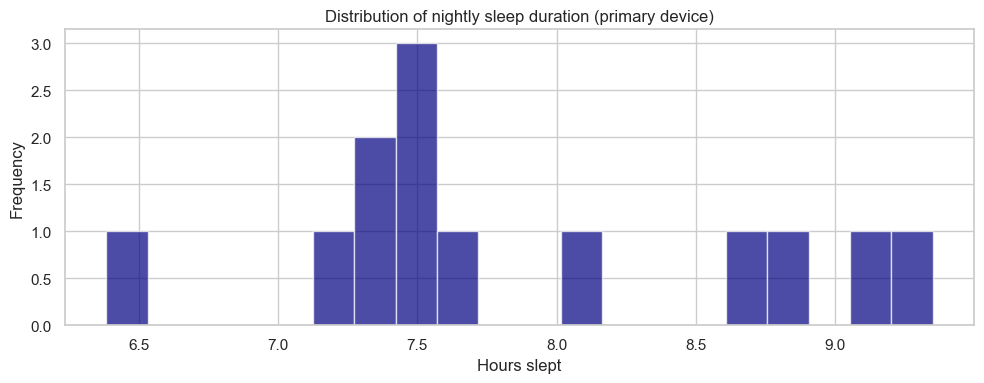

In [22]:
sleep_df = apple_df[apple_df["type"].str.contains("SleepAnalysis", na=False)].copy()

if sleep_df.empty:
    print("ℹ️ Sleep records not present in this export.")
else:
    sleep_df[["startDate", "endDate"]] = sleep_df[["startDate", "endDate"]].apply(
        pd.to_datetime, errors="coerce"
    )
    sleep_df = sleep_df.dropna(subset=["startDate", "endDate"])
    sleep_df["sleep_minutes"] = (
        sleep_df["endDate"] - sleep_df["startDate"]
    ).dt.total_seconds() / 60
    sleep_df = sleep_df[sleep_df["sleep_minutes"] > 0]
    sleep_df["event_date"] = sleep_df["startDate"].dt.floor("D")

    def _union_hours(group: pd.DataFrame) -> float:
        """Merge overlapping intervals and return total hours slept."""
        intervals = sorted(group.itertuples(index=False, name=None), key=lambda x: x[0])
        merged: list[list[pd.Timestamp]] = []
        for start, end in intervals:
            if not merged or start > merged[-1][1]:
                merged.append([start, end])
            else:
                merged[-1][1] = max(merged[-1][1], end)
        total_seconds = sum((end - start).total_seconds() for start, end in merged)
        return total_seconds / 3600

    nightly_union = (
        sleep_df.groupby(["sourceName", "event_date"])[["startDate", "endDate"]]
        .apply(_union_hours)
        .rename("hours")
        .reset_index()
    )

    if nightly_union.empty:
        print(
            "⚠️ Unable to compute sleep duration union; please verify source intervals."
        )
    else:
        source_stats = (
            nightly_union.groupby("sourceName")["hours"]
            .agg(["count", "median", "mean", "min", "max"])
            .sort_values("median", ascending=False)
        )

        display(Markdown("**Sleep source coverage (union hours):**"))
        display(source_stats)

        candidate_sources = source_stats.loc[
            (source_stats["median"] >= 3) & (source_stats["median"] <= 10)
        ]
        if not candidate_sources.empty:
            preferred_source = candidate_sources.sort_values(
                ["count", "median"], ascending=[False, False]
            ).index[0]
        else:
            preferred_source = source_stats.index[0]

        print(
            f"✨ Using '{preferred_source}' as primary sleep source for nightly totals."
        )

        nightly_sleep_hours = (
            nightly_union[nightly_union["sourceName"] == preferred_source]
            .set_index("event_date")["hours"]
            .sort_index()
        )

        if nightly_sleep_hours.empty:
            print("⚠️ No nightly totals available for the selected sleep source.")
        else:
            display(
                Markdown("**Nightly sleep duration (hours) — primary source only:**")
            )
            display(nightly_sleep_hours.tail(14).to_frame(name="hours"))

            fig = px.bar(
                nightly_sleep_hours.reset_index(name="sleep_hours"),
                x="event_date",
                y="sleep_hours",
                title="Sleep duration by night (primary device)",
                labels={"event_date": "Date", "sleep_hours": "Sleep (hours)"},
            )
            fig.update_traces(marker_color="midnightblue")
            fig.add_hrect(
                y0=7,
                y1=9,
                fillcolor="lightgreen",
                opacity=0.2,
                line_width=0,
                annotation_text="Target 7-9h",
            )
            fig.show()

            plt.figure(figsize=(10, 4))
            plt.hist(
                nightly_sleep_hours, bins=20, color="navy", alpha=0.7, edgecolor="white"
            )
            plt.title("Distribution of nightly sleep duration (primary device)")
            plt.xlabel("Hours slept")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

> **Note:** Sleep intervals often come from multiple apps and can overlap. The logic above merges overlapping windows per device, surfaces coverage stats for each source, and automatically selects the source whose median nightly duration falls inside a realistic 3–10 hour range (falling back to the top source when needed). Adjust `preferred_source` selection if you want to run comparisons across devices.

### 9. Type-level summary statistics

In [23]:
type_summary = pd.DataFrame()

if apple_df.empty:
    print("⚠️ Skipping type-level summary; dataframe is empty.")
else:
    numeric_df = apple_df.dropna(subset=["value_numeric"])
    if numeric_df.empty:
        print("ℹ️ No numeric value columns available for type summary.")
    else:
        type_summary = (
            numeric_df.groupby("type_clean")
            .agg(
                records=("value_numeric", "count"),
                sources=("sourceName", "nunique"),
                mean_value=("value_numeric", "mean"),
                median_value=("value_numeric", "median"),
                std_value=("value_numeric", "std"),
                min_value=("value_numeric", "min"),
                max_value=("value_numeric", "max"),
                first_timestamp=("startDate", "min"),
                last_timestamp=("startDate", "max"),
            )
            .sort_values("records", ascending=False)
        )
        display(type_summary.head(15))

,records,sources,mean_value,median_value,std_value,min_value,max_value,first_timestamp,last_timestamp
type_clean,,,,,,,,,
HeartRate,33396,2,78.716,76.000,19.526,4.400e+01,160.000,2025-08-16 13:20:00,2025-08-30 17:54:00
ActiveEnergyBurned,26578,2,0.558,0.173,1.451,1.000e-03,35.000,2025-08-16 13:20:00,2025-08-30 17:53:17
BasalEnergyBurned,18849,1,1.366,0.063,5.891,4.800e-02,69.890,2025-08-16 13:27:43,2025-08-30 17:52:57
RespiratoryRate,9007,2,14.047,14.000,1.098,9.000e+00,35.000,2025-08-17 01:10:24,2025-08-30 09:25:00
PhysicalEffort,7658,1,3.742,3.700,1.813,1.000e+00,20.000,2025-08-16 13:22:36,2025-08-30 17:52:31
DistanceCycling,3478,2,0.004,0.002,0.097,4.508e-06,4.344,2025-08-19 18:40:57,2025-08-27 18:12:47
DistanceWalkingRunning,2460,3,0.056,0.025,0.106,1.495e-04,2.898,2025-08-16 13:21:55,2025-08-30 17:52:18
AppleExerciseTime,1910,2,1.000,1.000,0.000,1.000e+00,1.000,2025-08-16 14:38:00,2025-08-30 16:23:00
StepCount,1868,2,151.260,57.000,224.716,1.000e+00,1092.000,2025-08-16 13:21:55,2025-08-30 17:52:18


### 10. Daily feature matrix

**Daily feature matrix preview:**

,mean_ActiveEnergyBurned,mean_AppleExerciseTime,mean_AppleStandTime,mean_AppleWalkingSteadiness,mean_BasalEnergyBurned,mean_BloodGlucose,mean_BodyFatPercentage,mean_BodyMass,mean_BodyMassIndex,mean_DietaryCarbohydrates,mean_DietaryCholesterol,mean_DietaryEnergyConsumed,mean_DietaryFatSaturated,mean_DietaryFatTotal,mean_DietaryFiber,mean_DietaryPotassium,mean_DietaryProtein,mean_DietarySodium,mean_DietarySugar,mean_DietaryWater,mean_DistanceCycling,mean_DistanceWalkingRunning,mean_EnvironmentalAudioExposure,mean_EnvironmentalSoundReduction,mean_FlightsClimbed,mean_HeadphoneAudioExposure,mean_HeartRate,mean_HeartRateVariabilitySDNN,mean_LeanBodyMass,mean_PhysicalEffort,mean_RespiratoryRate,mean_RestingHeartRate,mean_SixMinuteWalkTestDistance,mean_StepCount,mean_VO2Max,mean_WalkingAsymmetryPercentage,mean_WalkingDoubleSupportPercentage,mean_WalkingHeartRateAverage,mean_WalkingSpeed,mean_WalkingStepLength,sum_ActiveEnergyBurned,sum_AppleExerciseTime,sum_AppleStandTime,sum_AppleWalkingSteadiness,sum_BasalEnergyBurned,sum_BloodGlucose,sum_BodyFatPercentage,sum_BodyMass,sum_BodyMassIndex,sum_DietaryCarbohydrates,sum_DietaryCholesterol,sum_DietaryEnergyConsumed,sum_DietaryFatSaturated,sum_DietaryFatTotal,sum_DietaryFiber,sum_DietaryPotassium,sum_DietaryProtein,sum_DietarySodium,sum_DietarySugar,sum_DietaryWater,sum_DistanceCycling,sum_DistanceWalkingRunning,sum_EnvironmentalAudioExposure,sum_EnvironmentalSoundReduction,sum_FlightsClimbed,sum_HeadphoneAudioExposure,sum_HeartRate,sum_HeartRateVariabilitySDNN,sum_LeanBodyMass,sum_PhysicalEffort,sum_RespiratoryRate,sum_RestingHeartRate,sum_SixMinuteWalkTestDistance,sum_StepCount,sum_VO2Max,sum_WalkingAsymmetryPercentage,sum_WalkingDoubleSupportPercentage,sum_WalkingHeartRateAverage,sum_WalkingSpeed,sum_WalkingStepLength,count_ActiveEnergyBurned,count_AppleExerciseTime,count_AppleStandTime,count_AppleWalkingSteadiness,count_BasalEnergyBurned,count_BloodGlucose,count_BodyFatPercentage,count_BodyMass,count_BodyMassIndex,count_DietaryCarbohydrates,count_DietaryCholesterol,count_DietaryEnergyConsumed,count_DietaryFatSaturated,count_DietaryFatTotal,count_DietaryFiber,count_DietaryPotassium,count_DietaryProtein,count_DietarySodium,count_DietarySugar,count_DietaryWater,count_DistanceCycling,count_DistanceWalkingRunning,count_EnvironmentalAudioExposure,count_EnvironmentalSoundReduction,count_FlightsClimbed,count_HeadphoneAudioExposure,count_HeartRate,count_HeartRateVariabilitySDNN,count_LeanBodyMass,count_PhysicalEffort,count_RespiratoryRate,count_RestingHeartRate,count_SixMinuteWalkTestDistance,count_StepCount,count_VO2Max,count_WalkingAsymmetryPercentage,count_WalkingDoubleSupportPercentage,count_WalkingHeartRateAverage,count_WalkingSpeed,count_WalkingStepLength
event_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-08-21,0.440,1.0,2.247,1.000,0.685,97.657,0.145,153.803,22.704,9.950,48.851,91.042,1.094,6.231,2.730,358.140,10.118,80.386,5.284,0.0,NaN,0.043,59.556,16.728,2.583,73.664,86.632,28.503,131.373,3.817,14.133,60.5,NaN,166.884,NaN,0.006,0.275,87.5,2.796,28.789,1336.660,251.0,218.0,1.000,1805.960,9668.0,0.145,307.605,90.817,199.0,195.403,2185.0,13.130,81.0,35.489,3223.260,172.0,1366.567,84.544,0.0,NaN,9.605,1488.894,50.185,31.0,957.633,253137.933,142.517,131.373,2190.7,6091.5,121.0,NaN,20193.0,NaN,0.12,8.801,87.5,89.477,921.261,3039.0,251.0,97.0,1.0,2636.0,99.0,1.0,2.0,4.0,20.0,4.0,24.0,12.0,13.0,13.0,9.0,17.0,17.0,16.0,1.0,NaN,223.0,25.0,3.0,12.0,13.0,2922.0,5.0,1.0,574.0,431.0,2.0,NaN,121.0,NaN,21.0,32.0,1.0,32.0,32.0
2025-08-22,0.691,1.0,2.562,NaN,1.007,86.024,0.143,153.201,22.649,21.222,25.625,135.273,2.090,11.429,2.573,92.920,7.286,80.448,5.731,0.0,NaN,0.080,52.014,NaN,1.667,70.641,75.061,46.037,131.175,3.761,14.274,57.5,NaN,271.626,48.31,0.011,0.265,94.0,3.016,30.472,1637.791,268.0,269.0,NaN,1817.756,10839.0,0.143,153.201,67.947,191.0,51.250,1488.0,12.540,80.0,15.436,371.680,51.0,643.580,40.119,0.0,NaN,22

**Top cross-metric correlations:**

abs_correlation
mean_VO2Max       sum_LeanBodyMass                             1.0
                  sum_BodyMass                                 1.0
sum_LeanBodyMass  count_DistanceCycling                        1.0
mean_LeanBodyMass count_DistanceCycling                        1.0
mean_VO2Max       sum_PhysicalEffort                           1.0
mean_LeanBodyMass sum_DistanceCycling                          1.0
mean_VO2Max       mean_WalkingStepLength                       1.0
sum_VO2Max        sum_WalkingAsymmetryPercentage               1.0
mean_VO2Max       sum_WalkingAsymmetryPercentage               1.0
                  sum_DistanceWalkingRunning                   1.0
                  sum_DietarySodium                            1.0
                  mean_WalkingAsymmetryPercentage              1.0
                  sum_FlightsClimbed                           1.0
                  count_DistanceWalkingRunning                 1.0
                  sum_HeartRate                                1.0

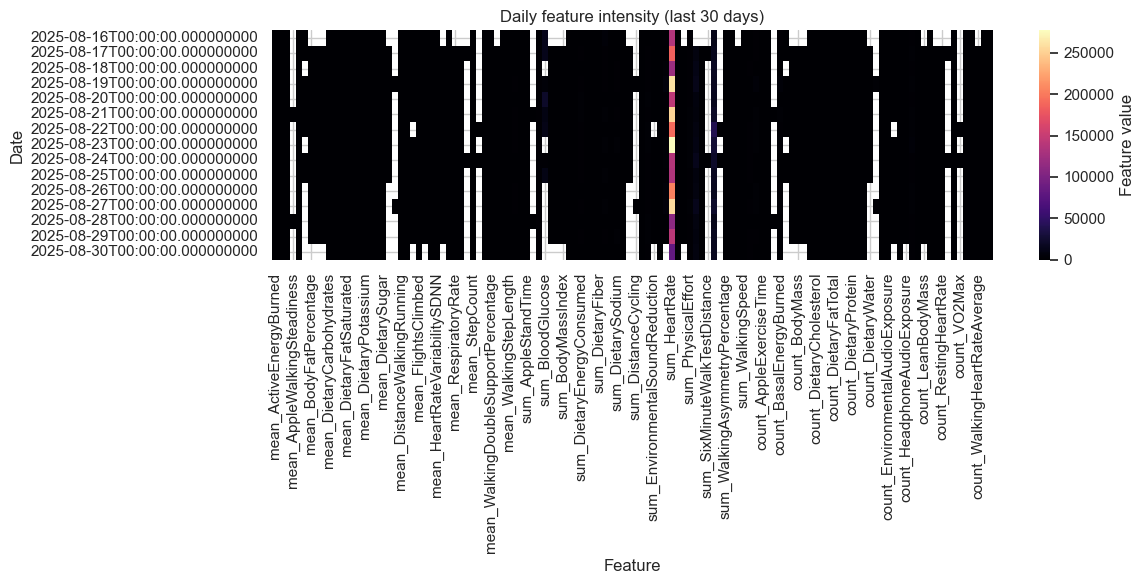

In [24]:
daily_features = pd.DataFrame()

if apple_df.empty or "event_date" not in apple_df.columns:
    print("⚠️ Cannot compute daily features without timestamped events.")
else:
    numeric_events = apple_df.dropna(subset=["value_numeric", "event_date"])
    if numeric_events.empty:
        print("ℹ️ No numeric events available for daily feature matrix.")
    else:
        daily_features = numeric_events.pivot_table(
            index="event_date",
            columns="type_clean",
            values="value_numeric",
            aggfunc=["mean", "sum", "count"],
        )
        daily_features.columns = [
            "_".join(col).strip() for col in daily_features.columns.to_flat_index()
        ]
        daily_features = daily_features.sort_index()

        display(Markdown("**Daily feature matrix preview:**"))
        display(daily_features.tail(10))

        numeric_matrix = daily_features.select_dtypes(include=[np.number])
        if numeric_matrix.shape[1] >= 2:
            corr_candidates = numeric_matrix.corr().abs()
            corr_top = (
                corr_candidates.where(
                    np.triu(np.ones(corr_candidates.shape), k=1).astype(bool)
                )
                .stack()
                .sort_values(ascending=False)
                .head(15)
                .to_frame(name="abs_correlation")
            )
            display(Markdown("**Top cross-metric correlations:**"))
            display(corr_top)
        else:
            print("ℹ️ Not enough numeric features for correlation analysis.")

        if not numeric_matrix.empty:
            plt.figure(figsize=(12, 6))
            sns.heatmap(
                numeric_matrix.tail(30),
                cmap="magma",
                cbar_kws={"label": "Feature value"},
            )
            plt.title("Daily feature intensity (last 30 days)")
            plt.xlabel("Feature")
            plt.ylabel("Date")
            plt.tight_layout()
            plt.show()

### 11. Export curated artifacts

In [25]:
exports = []

if "type_summary" in locals() and not type_summary.empty:
    type_summary_path = processed_dir / "apple_health_type_summary.csv"
    type_summary.reset_index().to_csv(type_summary_path, index=False)
    exports.append({"artifact": type_summary_path.name, "rows": len(type_summary)})

if "daily_features" in locals() and not daily_features.empty:
    daily_features_path = processed_dir / "apple_health_daily_features.csv"
    daily_features.to_csv(daily_features_path, index=True, index_label="event_date")
    exports.append({"artifact": daily_features_path.name, "rows": len(daily_features)})

if exports:
    print("💾 Export summary:")
    display(pd.DataFrame(exports))
else:
    print("ℹ️ No artifacts written (empty inputs).")

summary_metadata.setdefault("notebook_04", {})
summary_metadata["notebook_04"].update(
    {
        "run_timestamp": datetime.now().isoformat(),
        "apple_records": int(len(apple_df)),
        "type_summary_rows": (
            int(len(type_summary)) if "type_summary" in locals() else 0
        ),
        "daily_feature_rows": (
            int(len(daily_features)) if "daily_features" in locals() else 0
        ),
    }
)

with open(summary_path, "w") as f:
    json.dump(summary_metadata, f, indent=2, default=str)
    print(f"📝 Updated data_summary.json at {summary_path}")

💾 Export summary:


,artifact,rows
0,apple_health_type_summary.csv,40
1,apple_health_daily_features.csv,15


📝 Updated data_summary.json at ../data/processed/data_summary.json


### 12. Next steps
- Blend these Apple Health aggregates with Libre glucose features in Notebook 05
- Prototype circadian or habit-based clustering using the daily feature matrix
- Iterate on data-quality rules for new Apple Health exports (e.g., timezone reconciliation, outlier handling)